# NYC TRIP DURATION PREDICTION

In [1]:
#Import required library
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
import statsmodels.formula.api as sm
import statsmodels.regression.linear_model as sd
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
# Load the dataset
df = pd.read_csv("D:/nyc_taxi_trip_duration.csv")
print(df.head(5))


          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694

# Understanding the Data


This gives us the basic understanding of data 

In [3]:
#Number of Rows and Coulmns
Number_of_rows = len(df)
Number_of_columns= len(df.columns)
print("Number of rows = {}".format(Number_of_rows))
print("Number of columns = {}".format(Number_of_columns))
print("\n")
#Printing the columns datatypes
print("Data Types of each column values")
print(df.dtypes)
print("\n")


Number of rows = 729322
Number of columns = 11


Data Types of each column values
id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object




# Data Preprocessing and Data Exploration

Data Preprocessing is one of the most important technique which should be carried out before model building. Preprocessing the data can make avoid overfitting/underfitting of data in the model and biased results.
1. To check if the data has any null values.
2. Changing the inappropriate datatypes of columns
3. Removing unwanted columns


In [4]:
#Check if a column has null value
print(np.sum(pd.isnull(df)))

#Removing unwanted column
df=df.drop("id",axis=1)
df = df.drop_duplicates()




id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [5]:
#Converting datatypes of columns pickp and dop time,
#Changing categorical variable to numerical value 

df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])


le = LabelEncoder()
df["store_and_fwd_flag"] = le.fit_transform(df["store_and_fwd_flag"])

print(df.head(1))

   vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          2 2016-02-29 16:40:21 2016-02-29 16:47:01                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.953918        40.778873         -73.963875         40.771164   

   store_and_fwd_flag  trip_duration  
0                   0            400  


In [6]:
 #Feature creation
df['year']=df['pickup_datetime'].dt.year
df['month']=df['pickup_datetime'].dt.month
df['hour']=df['pickup_datetime'].dt.hour
df['day']=df['pickup_datetime'].dt.weekday


In [7]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(df):
    R = 6371  # radius of earth in km
    lat1, lon1, lat2, lon2 = map(radians, [df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude']])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c 
    return distance

df['distance'] = df.apply(haversine_distance, axis=1)
print(df.head(1))

   vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          2 2016-02-29 16:40:21 2016-02-29 16:47:01                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.953918        40.778873         -73.963875         40.771164   

   store_and_fwd_flag  trip_duration  year  month  hour  day  distance  
0                   0            400  2016      2    16    0  1.199073  


In [8]:
df['Speed']=df['distance']/(df['trip_duration']/3600)
print(df.head(2))

   vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          2 2016-02-29 16:40:21 2016-02-29 16:47:01                1   
1          1 2016-03-11 23:35:37 2016-03-11 23:53:57                2   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.953918        40.778873         -73.963875         40.771164   
1        -73.988312        40.731743         -73.994751         40.694931   

   store_and_fwd_flag  trip_duration  year  month  hour  day  distance  \
0                   0            400  2016      2    16    0  1.199073   
1                   0           1100  2016      3    23    4  4.129111   

       Speed  
0  10.791654  
1  13.513454  


In [9]:
def get_day_type(day):
    if day < 5:
        return 0
    else:
        return 1
    
df['day_type'] = df['day'].apply(get_day_type)
print(df.head(1))

   vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          2 2016-02-29 16:40:21 2016-02-29 16:47:01                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.953918        40.778873         -73.963875         40.771164   

   store_and_fwd_flag  trip_duration  year  month  hour  day  distance  \
0                   0            400  2016      2    16    0  1.199073   

       Speed  day_type  
0  10.791654         0  


# Univariate Analysis

Analysing variables individually to understand the data distribution and remove the possible outliers. 

Visualising the important factor which may contribute more in the model

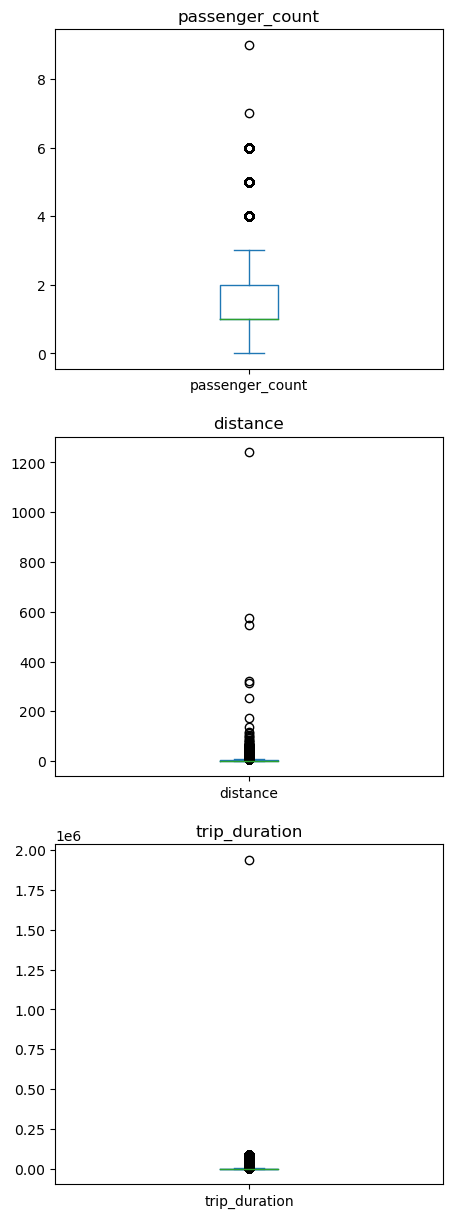

In [10]:
import matplotlib.pyplot as plt
columns = ['passenger_count','distance','trip_duration']
fig, ax = plt.subplots(len(columns), figsize=(5, 5*len(columns)))
for i, col in enumerate(columns):
    df[col].plot.box(ax=ax[i])
    ax[i].set_title(col)

# Show the plot
plt.show()

It seems to be there are outliers within the variables. We will analyse it closely and decide to remove the outliers and change the outliers with appropriate value


##PASSENGERS COUNT

In [11]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
df.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

In [12]:
df.passenger_count.describe()


count   729322.00
mean         1.66
std          1.31
min          0.00
25%          1.00
50%          1.00
75%          2.00
max          9.00
Name: passenger_count, dtype: float64

Changing the 0 passenger to 1 and removing the outliers

In [13]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)
df = df[df.passenger_count <= 6]
df.passenger_count.value_counts()

1    517448
2    105097
5     38926
3     29692
6     24107
4     14050
Name: passenger_count, dtype: int64

Visualising the final

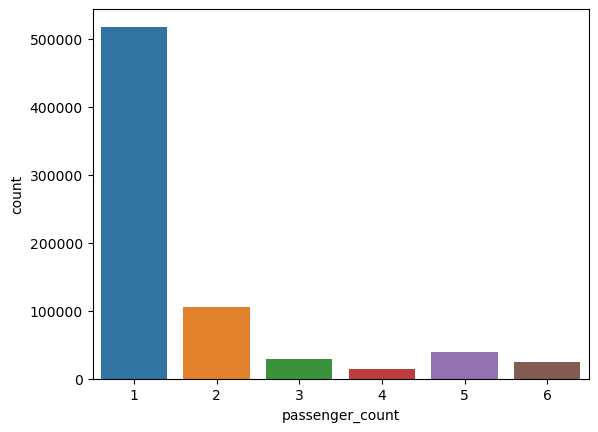

In [14]:
import seaborn as sns
sns.countplot(df.passenger_count)
plt.show()

Vendor

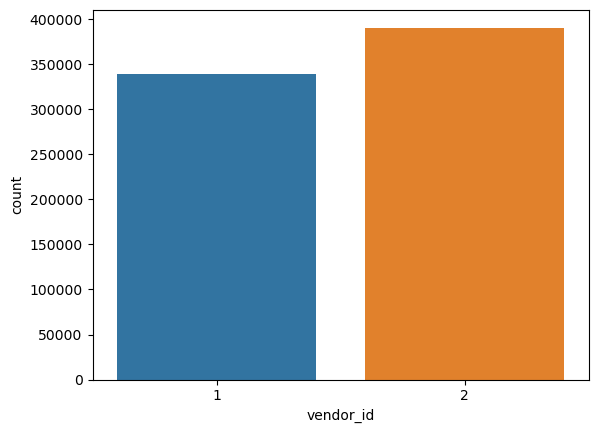

In [15]:
sns.countplot(df.vendor_id)
plt.show()

Distance

In [16]:
print(df.distance.describe())


count   729320.00
mean         3.44
std          4.35
min          0.00
25%          1.23
50%          2.10
75%          3.88
max       1240.91
Name: distance, dtype: float64


Visualising distance in log to visualize better

In [17]:
sf=df.distance[df.distance == 0 ].count()
sf

2900

We are not removing the distance which is noted as 0 and can be used to analyse teh correaltion between distance and trip duration

Trip Duration

In [18]:
df.trip_duration.describe()


count    729320.00
mean        952.23
std        3864.63
min           1.00
25%         397.00
50%         663.00
75%        1075.00
max     1939736.00
Name: trip_duration, dtype: float64

In [19]:
bucket=pd.DataFrame(df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,max(df.trip_duration),3600))).count())
bucket.head(30)

,trip_duration
trip_duration,
"(1, 3601]",723251
"(3601, 7201]",4964
"(7201, 10801]",61
"(10801, 14401]",15
"(14401, 18001]",2
"(18001, 21601]",6
"(21601, 25201]",6
"(25201, 28801]",10
"(28801, 32401]",12


86400 seconds is 1 day and most of the trips are done in 1 day. we will remove trips which took more tha 1 day to avoid discripancies

df = df[df.trip_duration <= 86400]
df

Exploring trip duration in minutes slab

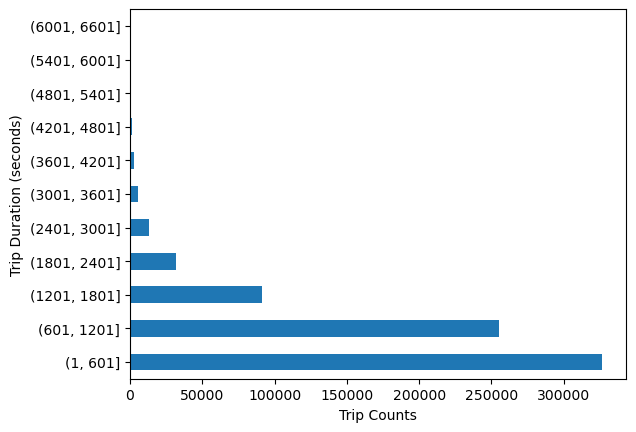

In [20]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

Most of trip duration took around 30 mins approx

Speed

In [21]:
df.Speed.describe()

count   729320.00
mean        14.42
std         12.34
min          0.00
25%          9.12
50%         12.80
75%         17.84
max       5640.49
Name: Speed, dtype: float64

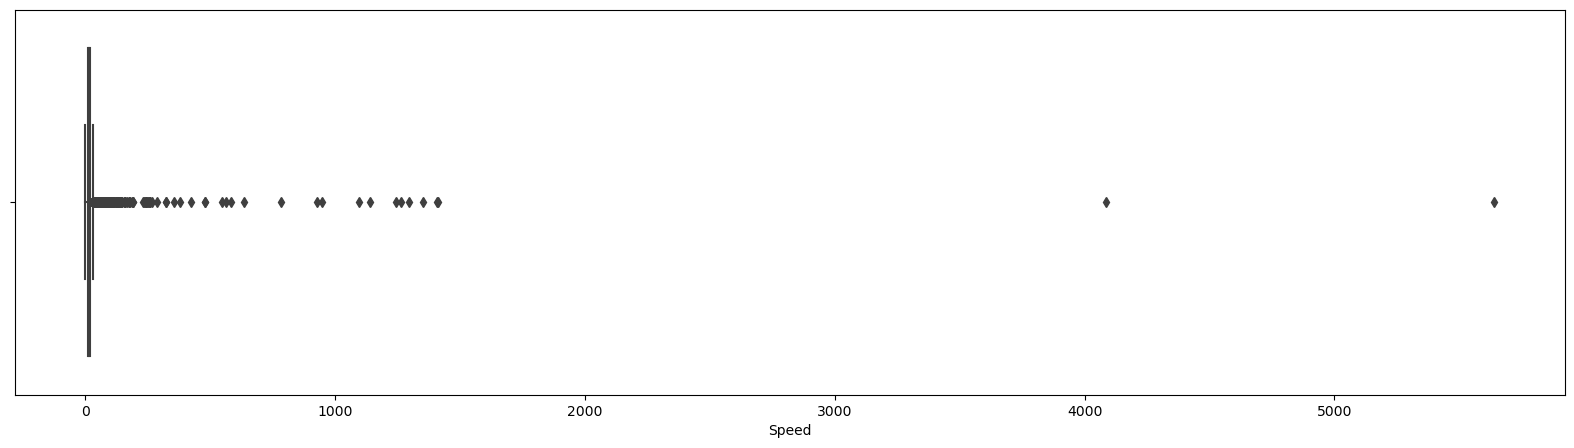

In [22]:
plt.figure(figsize = (20,5))
sns.boxplot(df.Speed)
plt.show()

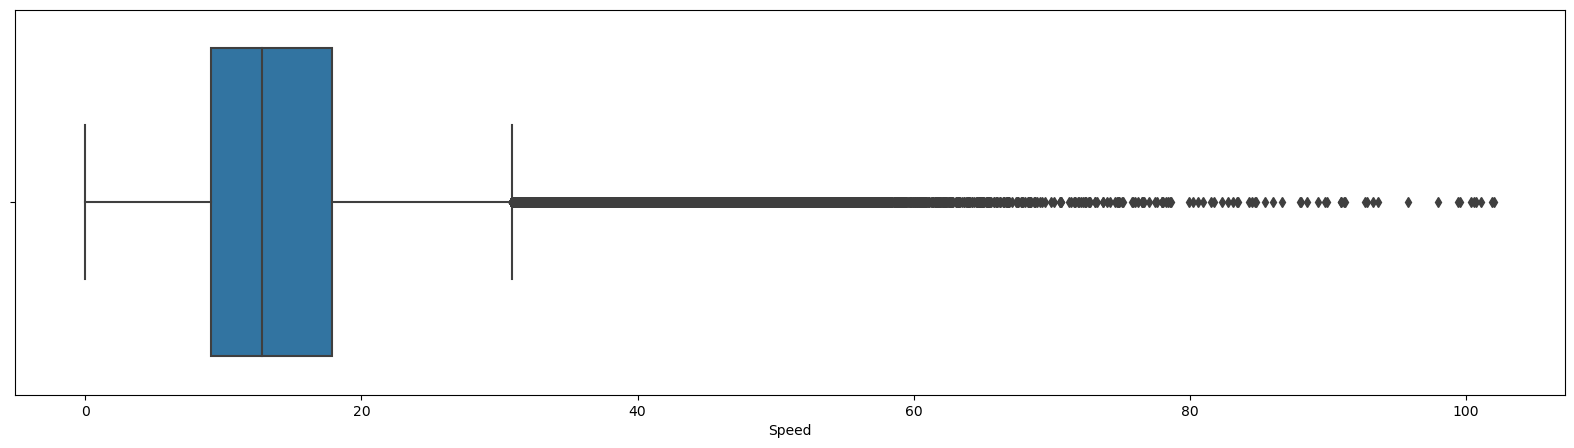

In [23]:
df = df[df.Speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(df.Speed)
plt.show()

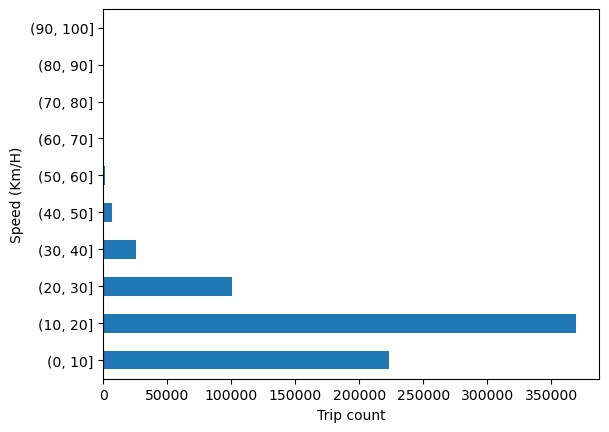

In [24]:
df.Speed.groupby(pd.cut(df.Speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

Store_and_fwd_flag



In [25]:
df.store_and_fwd_flag.value_counts()


0    725201
1      4039
Name: store_and_fwd_flag, dtype: int64

In [26]:
df.vendor_id[df.store_and_fwd_flag == 1].value_counts()


1    4039
Name: vendor_id, dtype: int64

Almost most of the offline trips are undertook by Vendor 1.

Total Trips per hour

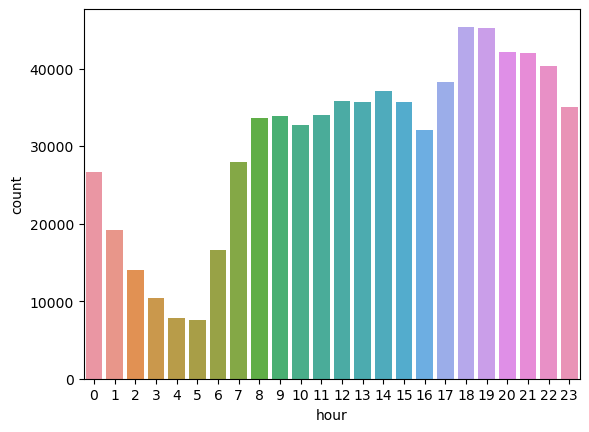

In [27]:
sns.countplot(df.hour)
plt.show()

Number of Trips increases from early morning and gradually increases till 8 in evening and decreases once again.

Total trips based on day_type

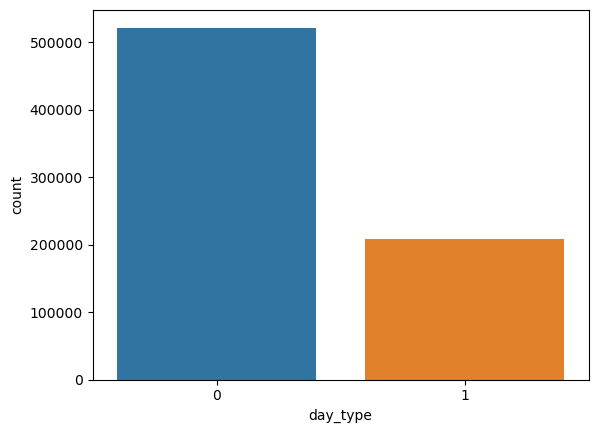

In [28]:
sns.countplot(df.day_type)
plt.show()

Most of the trips are happened during week days rather than week ends
Let us analyse the week end trips to check the correlation between distance and week ends

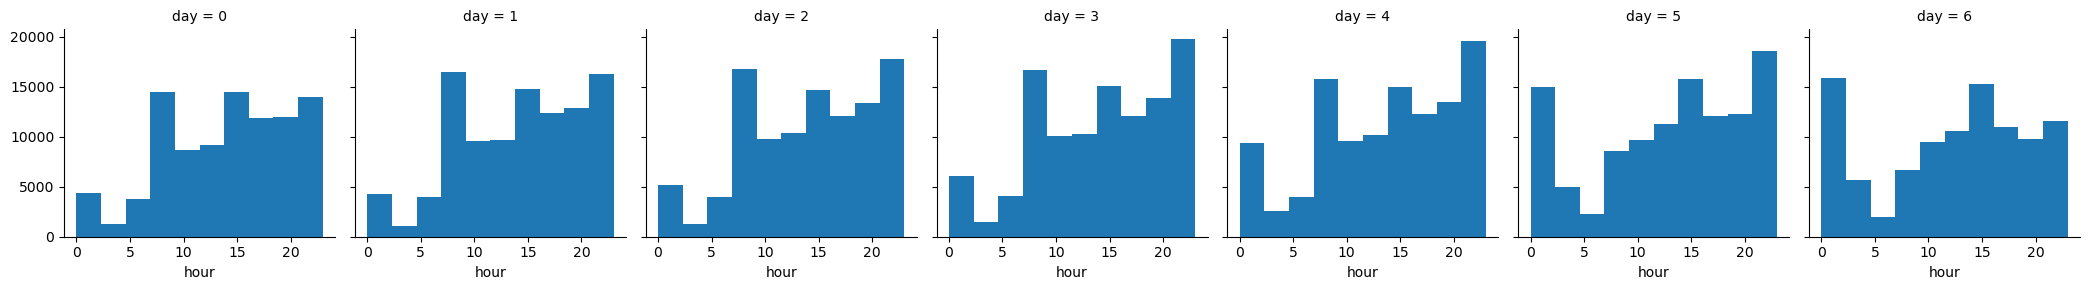

In [29]:
n = sns.FacetGrid(df, col='day')
n.map(plt.hist, 'hour')
plt.show()

1.Taxi pickups are more during late hours but it is least on sunday
2. Morning picks (7-9) is comparatively higher during week days

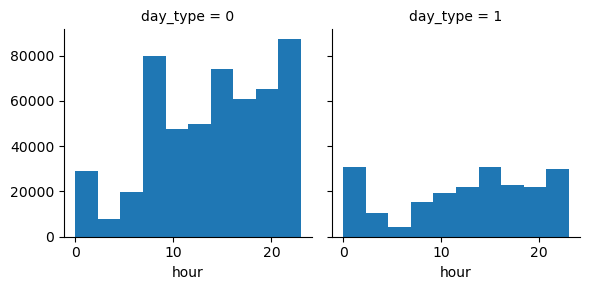

In [30]:
n = sns.FacetGrid(df, col='day_type')
n.map(plt.hist, 'hour')
plt.show()

Comparision of week ends and week days with trip hours

Trips based on Months

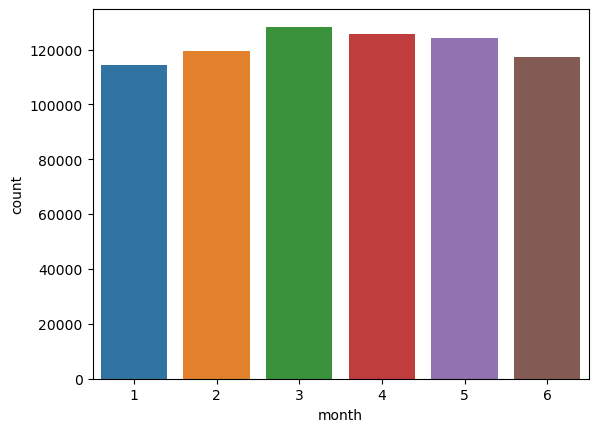

In [31]:
sns.countplot(df.month)
plt.show()

The trips are almost distributed equally

# Bi Variate Analysis

 Trip Duration per hour


We are aggregating the trip duration(mean) and will plot against hour. This will help us to understand the traffic

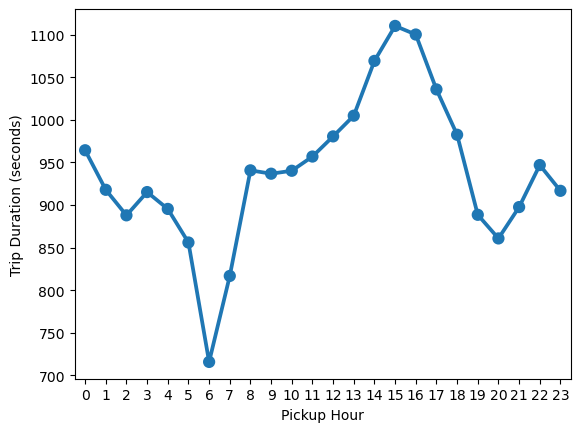

In [32]:
group1 = df.groupby('hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

The average trip duration gradually increased around 8 which is a prime work time and increasing over and over till 3 pm and decreases.
The traffic is more during the day time rather than night.

# #   Trip duration per week


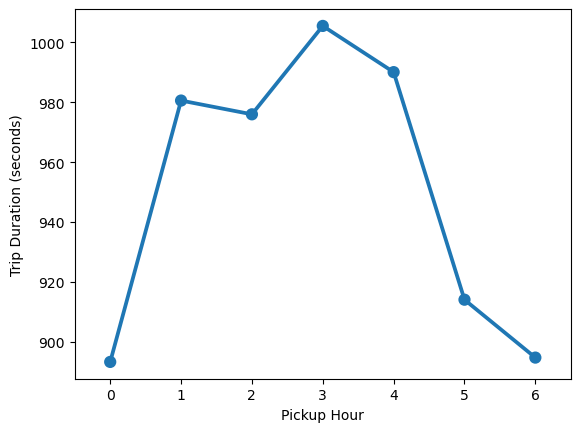

In [33]:
group1 = df.groupby('day').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

The average trip duration is increased during mid week days from Tuesday to Friday, showing highest during Thursday.

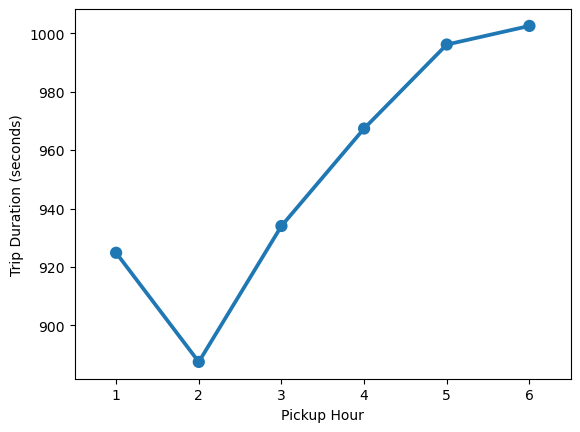

In [34]:
group1 = df.groupby('month').trip_duration.mean()
vendor = df.vendor_id
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

The trip duraion is least during month of February and gradually increasing from March. It must be due to the season where Newyork has rains during May whcih may resulted in increased average trip duration time.

**Trip duration per vendor**

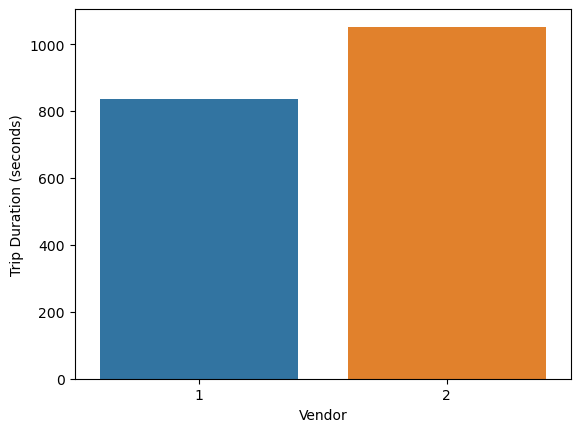

In [35]:
  group4 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

**On Average, Trip duration is higher for vendor 2 by 300 mins which is around 5 mins**

**Distance per hour**

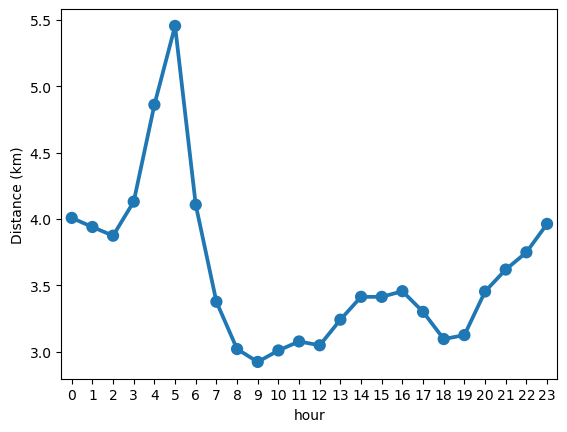

In [36]:
group5 = df.groupby('hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

OBSERVATION

1. Trip Distance is fairly high during early morning, considering people make early morning trips for long distance to avoid traffic and reach destination earlier.

**Distance per weekday**


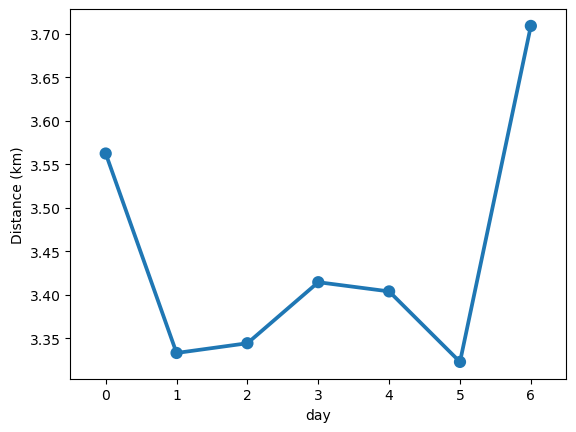

In [37]:
group6 = df.groupby('day').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

**OBSERVATION**

1. The trip distance is higher over weekends than week days.

**Distance v/s Trip duration**

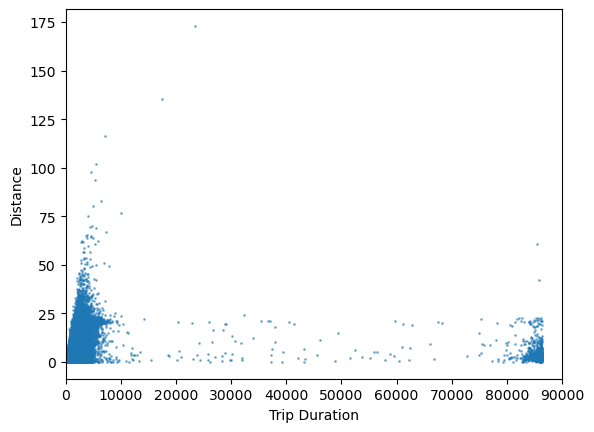

In [38]:
from matplotlib.ticker import FormatStrFormatter
plt.scatter(x=df.trip_duration, y=df.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.xlim(0,90000)
plt.show()

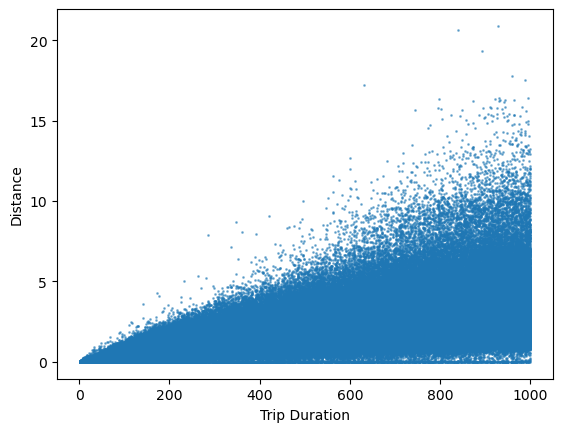

In [39]:
dur_dist = df.loc[(df.trip_duration >= 0) & (df.trip_duration <= 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

From the above figure, We can notice that some of the trips which covered only 0 km took trip_duration time more than 1 min. Considering it will take only 1 minute to cancel the trip, we will revome inappropriate data such as 1hr took to cover 1km distance, will be to removeing them as ouliers

In [40]:
df = df[~((df.distance == 0) & (df.trip_duration >= 60))]


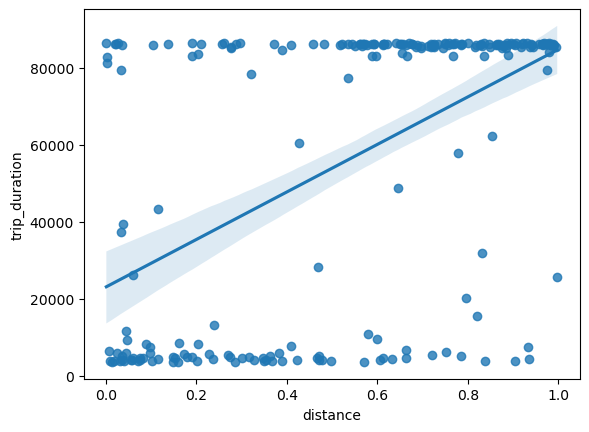

In [41]:
duo = df.loc[(df['distance'] <= 1) & (df['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

It seems that many trips which has distance less than 1 took more than a day to get completed which is absurd, So we will also remove trips which has distance less than or equal to 1 but took more than 1 hr to complete. Between we can notice **Distance and Trip duration has positive linear relationship**. 

In [42]:
df = df[~((df.distance <= 1) & (df.trip_duration <= 3600))]


**Average speed per hour**

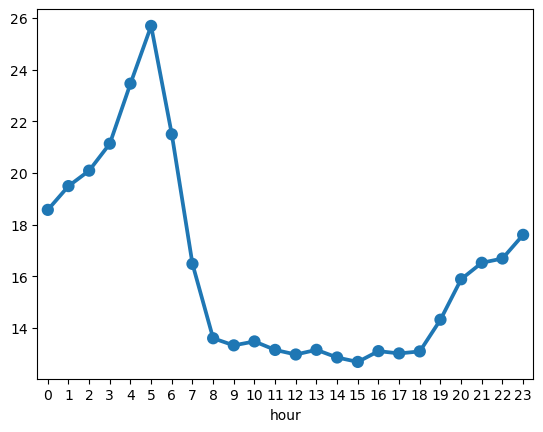

In [43]:
group = df.groupby('hour').Speed.mean()
sns.pointplot(group.index, group.values)
plt.show()

Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
The taxi speed looks increased during early morning might be due to less traffic.

**Average speed per weekday**

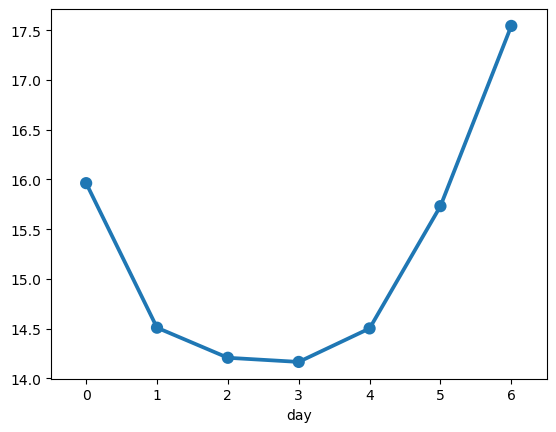

In [44]:
group10 = df.groupby('day').Speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

The Average speed seems to be incresed during week ends rather than week days

**Passenger count per vendor**

Let us visualise which vendor had took more passengers for trip


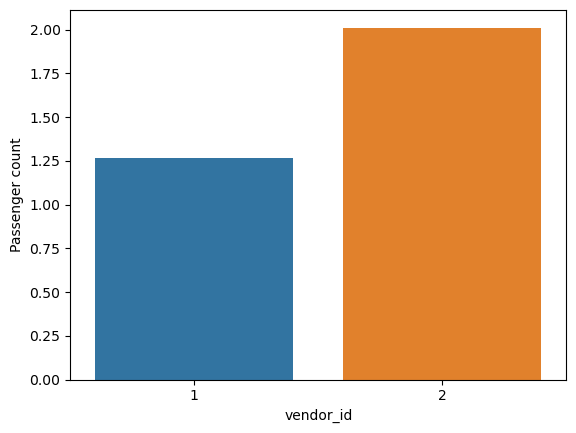

In [45]:
group9 = df.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.show()

It seems vendor 2 has travelled with more passengers than vendor 1. We will split down the distribution by passenger count and check. 

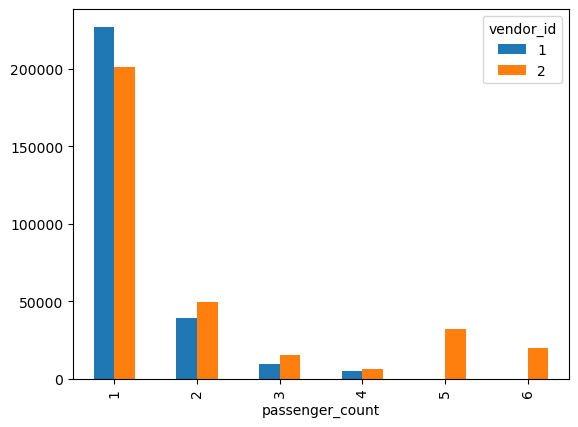

In [46]:
df.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

After splitting down the distribution, we can notice that Vendor 1 carried mostly 1 passenger and vendor 2 travelled more with paasenger counts more than 1.

# Feature Engineering

Lets get or build features for model building. Let us OLS regression to understand teh weightage of each feature gets in a model building

In [47]:
list(zip( range(0,len(df.columns)),df.columns))


[(0, 'vendor_id'),
 (1, 'pickup_datetime'),
 (2, 'dropoff_datetime'),
 (3, 'passenger_count'),
 (4, 'pickup_longitude'),
 (5, 'pickup_latitude'),
 (6, 'dropoff_longitude'),
 (7, 'dropoff_latitude'),
 (8, 'store_and_fwd_flag'),
 (9, 'trip_duration'),
 (10, 'year'),
 (11, 'month'),
 (12, 'hour'),
 (13, 'day'),
 (14, 'distance'),
 (15, 'Speed'),
 (16, 'day_type')]

let us build a OLS model

In [48]:
X1=df.loc[:,['vendor_id','passenger_count','store_and_fwd_flag','year','month','hour','day','distance','Speed','day_type']]
Y1=df.loc[:,['trip_duration']]

In [49]:
print(X1.head(1))

   vendor_id  passenger_count  store_and_fwd_flag  year  month  hour  day  \
0          2                1                   0  2016      2    16    0   

   distance  Speed  day_type  
0      1.20  10.79         0  


In [50]:

from sklearn import preprocessing
print("Scale all the columns successfully done") 
X = preprocessing.scale(X1)
X = pd.DataFrame(X, columns=X1.columns)
Y = preprocessing.scale(Y1)
Y = pd.DataFrame(Y, columns=Y1.columns)

Scale all the columns successfully done


Let us remove the headers of thedata

In [51]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)
print(X1.shape)

(606459, 11)


In [52]:
X_opt = X1[:,range(0,11)]
regressor_OLS = sd.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sd.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

Probability values of each feature 

const   1.00
x1      0.00
x2      0.07
x3      0.73
x4      0.00
x5      0.28
x6      0.00
x7      0.94
x8      0.00
x9      0.00
x10     0.00
dtype: float64


Feature at index 0 is removed 

9 dimensions remaining now... 


Probability values of each feature 

x1      0.00
x2      0.07
x3      0.73
const   0.00
x4      0.28
x5      0.00
x6      0.94
x7      0.00
x8      0.00
x9      0.00
dtype: float64


Feature at index 6 is removed 

8 dimensions remaining now... 


Probability values of each feature 

x1      0.00
x2      0.07
x3      0.73
const   0.00
x4      0.28
x5      0.00
x6      0.00
x7      0.00
x8      0.00
dtype: float64


Feature at index 2 is removed 

7 dimensions remaining now... 


Probability values of each feature 

x1      0.00
x2      0.07
const   0.00
x3      0.28
x4      0.00
x5      0.00
x6      0.00
x7      0.00
dtype: float64


Feature at index 3 is removed 

6 dimensions remaining now... 


Probability values of each fea

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          trip_duration   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                              5184.
Date:                Tue, 21 Feb 2023   Prob (F-statistic):                        0.00
Time:                        22:03:29   Log-Likelihood:                     -8.4784e+05
No. Observations:              606459   AIC:                                  1.696e+06
Df Residuals:                  606454   BIC:                                  1.696e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0284      0.001     22.588      0.000       0.026       0.031
const       1.419e-16   1.07e-18    132.417      0.000     1.4e-16    1.44e-16
x2            -0.0148      0.001    -11.601      0.000      -0.017      -0.012
x3             0.2306      0.002    151.271      0.000       0.228       0.234
x4            -0.1945      0.002   -126.013      0.000      -0.198      -0.191
x5             0.0103      0.001      8.072      0.000       0.008       0.013
===============================================================================
Omnibus:                  2885721.008   Durbin-Watson:                    2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   157416846060618.500
Skew:                         180.769   Prob(JB):                          0.00
Kurtosis:                   78930.064   Cond. No.                      3.51e+17
===============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 7.86e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

OLS regression converted the 11 features to 5. The p value of sll feature is <0.05. Now we will split the OLS Data to correlation analysis

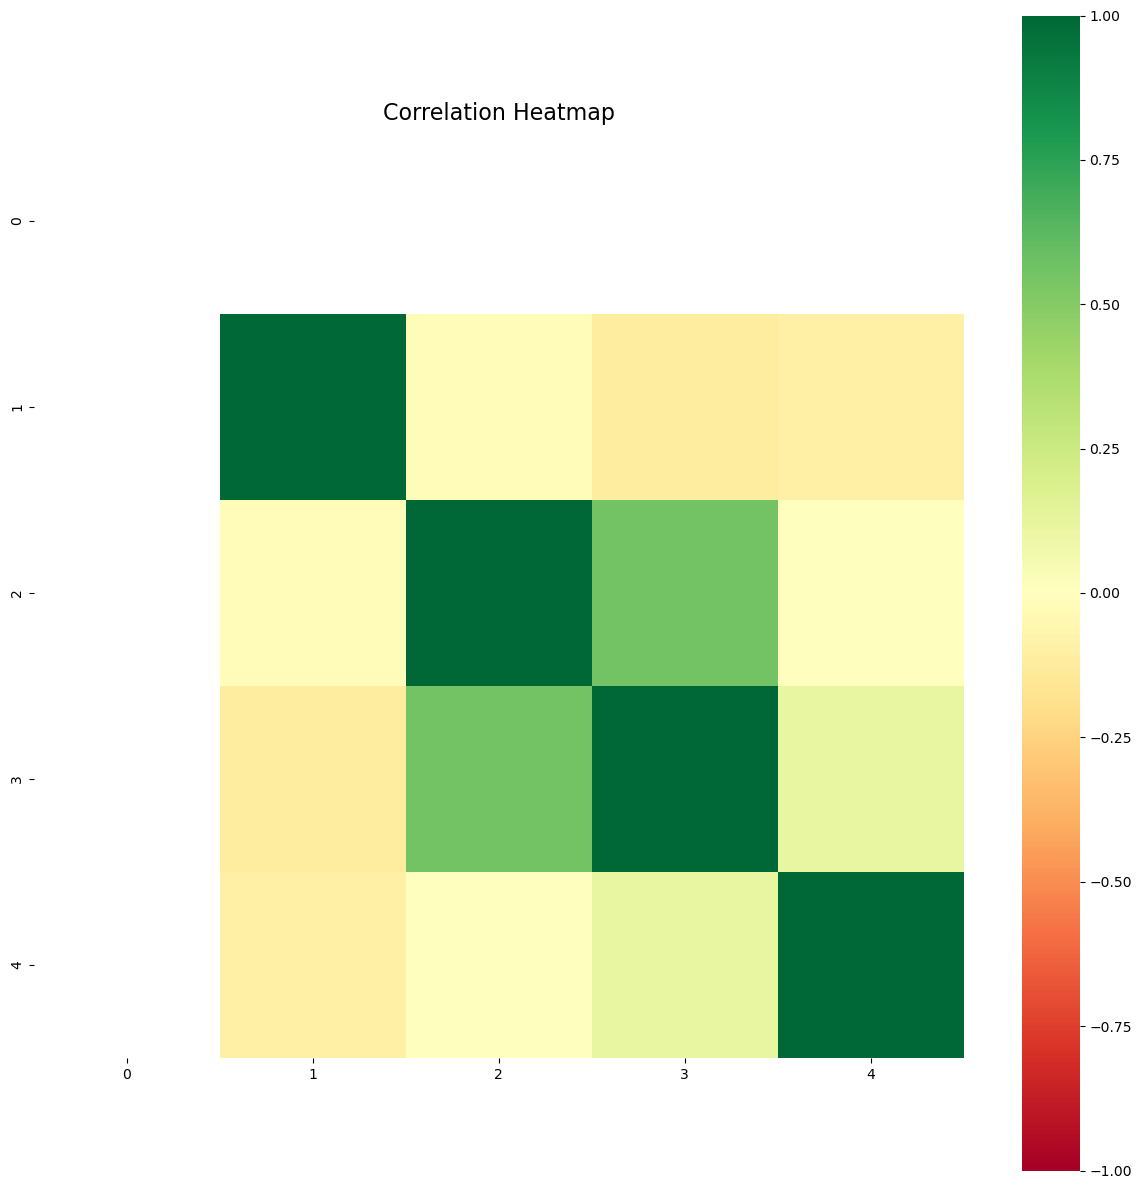

In [53]:
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

**Observation**
1. most of the features doesnt have a correlation.
2. Even thouugh feature 3 and 4 are correlated, their correlationn coefficient is not more than 0.075.

**Notes**
We can proceed to use the feature created dataset to build a model


Now, we will proceed to Feature Extraction using PCA

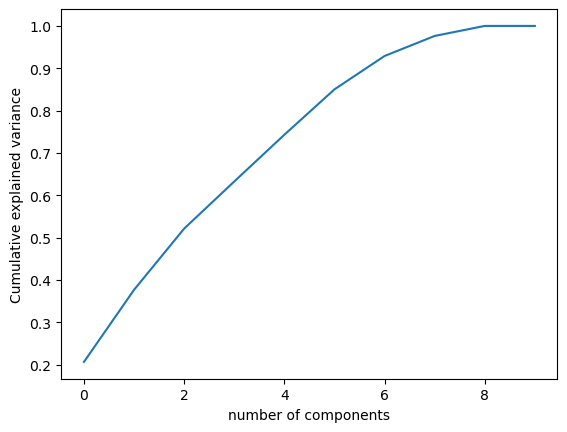

[(1, 20.65),
 (2, 37.68),
 (3, 52.129999999999995),
 (4, 63.25999999999999),
 (5, 74.29999999999998),
 (6, 85.01999999999998),
 (7, 92.89999999999998),
 (8, 97.62999999999998),
 (9, 99.99999999999999)]

In [54]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

We can see that around 9 attributes has around 99% variance. We will build our PCA using 9 components and check for the correlation.

In [55]:
pca_model = PCA(n_components=8)
X_train_pca = pca_model.fit_transform(X_train_pca)
X_test_pca = pca_model.transform(X_test_pca)

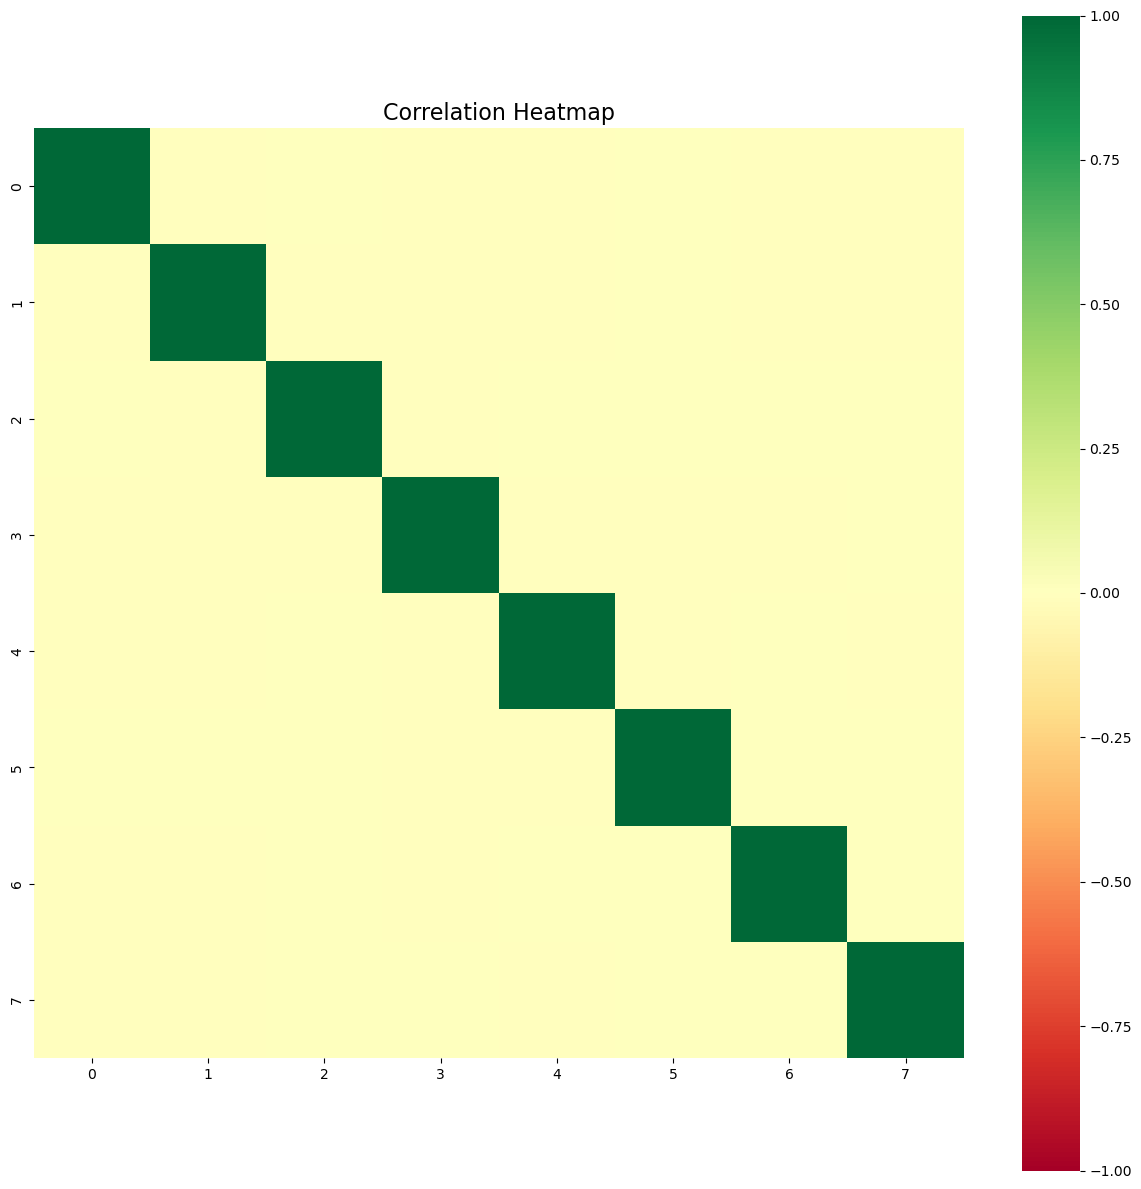

In [56]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

There is no-correlation between the features.

# Model Building

**Evaluation Metric**

**1. Root Mean Squared Error (RMSE)** is a commonly used evaluation metric for regression problems in machine learning. 
Mean squared error states that finding the squared difference between actual and predicted value. RMSE is a simple square root of mean squared error.
The Reason we choose RMSE as Evaluation Metric
1. RMSE has the same unit of measurement as the target variable, which makes it easy to interpret.
2. RMSE gives more weight to large errors, which can be particularly useful in applications where large errors are more important to avoid than small errors.
Lower values of RMSE indicate better model performance.

**2 . Benchmark Model for the DATASET**

In [57]:
X_train = pd.DataFrame(X_train, columns = X.columns)
benchmark_train = pd.concat([X_train, y_train], axis=1, join="inner")
benchmark_test = pd.concat([X_test, y_test], axis=1, join="inner")
benchmark_test['simple_mean'] = benchmark_train['trip_duration'].mean()
error = sqrt(mean_squared_error(benchmark_test['trip_duration'], benchmark_test['simple_mean']))
print("R-squared score of simple mean model of pca data: ", error)

R-squared score of simple mean model of pca data:  0.7976087162061379


**Note: We have two different datasets generated from PCA and OLS, we will compare them separately to understand how model is well built**

**Linear Model with Regularisation**

We will build a regression model with regularisation parameter Ridge

In [58]:
Test_scores_pca= []
Test_scores_fs= []



**Ridge Model for Both PCA and FS data set**

In [59]:
# Ridge with PCA Dataset

alpha = 0.8
model = Ridge(alpha=alpha)

model.fit(X_train_pca, y_train_pca)
train_pred = model.predict(X_train_pca)
mse_train = sqrt(mean_squared_error(y_train_pca,train_pred))


y_pred = model.predict(X_test_pca)
mse = sqrt(mean_squared_error(y_test_pca, y_pred))

print("RIDGE USING PCA DATA SET")
print("Mean Squared Error of Train PCA Data: ", mse_train)
print("Mean Squared Error of Test PCA Data: ", mse)
PCA_dict={}
PCA_dict['model']="Linear Regression(Ridge)"
PCA_dict['Train_score'] = mse_train
PCA_dict['Test_score'] = mse
Test_scores_pca.append(PCA_dict)
print(Test_scores_pca)

model.fit(X_train_fs, y_train_fs)
train_pred = model.predict(X_train_fs)
mse_train = sqrt(mean_squared_error(y_train_fs,train_pred))


y_pred = model.predict(X_test_fs)
mse = sqrt(mean_squared_error(y_test_fs, y_pred))

print("RIDGE USING FS DATA SET")
print("Mean Squared Error of Train FS Data: ", mse_train)
print("Mean Squared Error of Test FS Data: ", mse)
FS_dict={}
FS_dict['model']="Linear Regression(Ridge)"
FS_dict['Train_score'] = mse_train
FS_dict['Test_score'] = mse
Test_scores_fs.append(FS_dict)
print(Test_scores_fs)

RIDGE USING PCA DATA SET
Mean Squared Error of Train PCA Data:  1.012653407633636
Mean Squared Error of Test PCA Data:  0.8334387482675543
[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.012653407633636, 'Test_score': 0.8334387482675543}]
RIDGE USING FS DATA SET
Mean Squared Error of Train FS Data:  1.0125229479345839
Mean Squared Error of Test FS Data:  0.8332366104991389
[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.0125229479345839, 'Test_score': 0.8332366104991389}]


**KNN Regressor**

We will build a KNN model with 5 neighbors and then proceed to check the optimum neighbor count using elbow method

RMSE of knn model:  0.4943493582613989


Text(0.5, 1.0, 'Elbow curve for test')

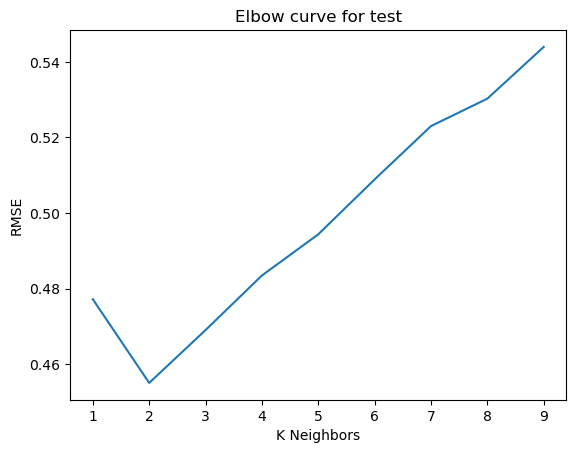

In [60]:
# KNN for PCA DATASET
knnr = KNeighborsRegressor(n_neighbors=5)
knnr.fit(X_train_pca, y_train_pca)
y_pred = knnr.predict(X_test_pca)
error = sqrt(mean_squared_error(y_test_pca, y_pred))

print("RMSE of knn model: ", error)

# Elbow curve to determine the K value
def elbow(k):
    test = []
    for i in k:
        reg = KNeighborsRegressor(n_neighbors=i)
        reg.fit(X_train_pca, y_train_pca)

        tmp_pred = reg.predict(X_test_pca)
        temp_error = sqrt(mean_squared_error(tmp_pred, y_test_pca))
        test.append(temp_error)
    return test
k = range(1,10)
test= elbow(k)


# plotting the curve

plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('RMSE')
plt.title('Elbow curve for test')

**Elbow Curve test provides the best k bvalue for pca data is 2. We will build the model with k = 2

In [61]:
knnr = KNeighborsRegressor(n_neighbors=2)
knnr.fit(X_train_pca, y_train_pca)
test_pred = knnr.predict(X_test_pca)
train_pred = knnr.predict(X_train_pca)
KNN_error_train_pca = sqrt(mean_squared_error(y_train_pca,train_pred))
KNN_error_test_pca = sqrt(mean_squared_error(y_test_pca, test_pred))

print("KNN Model for pca Dataset")
print("RMSE of Trained PCA DATASET:", KNN_error_train_pca)
print("RMSE of Test PCA Dataset:", KNN_error_test_pca)
PCA_dict={}
PCA_dict['model']="KNN"
PCA_dict['Train_score'] = KNN_error_train_pca
PCA_dict['Test_score'] = KNN_error_test_pca
Test_scores_pca.append(PCA_dict)
print(Test_scores_pca)

KNN Model for pca Dataset
RMSE of Trained PCA DATASET: 0.3999022527613862
RMSE of Test PCA Dataset: 0.45501658587355925
[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.012653407633636, 'Test_score': 0.8334387482675543}, {'model': 'KNN', 'Train_score': 0.3999022527613862, 'Test_score': 0.45501658587355925}]


RMSE of knn model:  0.1964901655033372


Text(0.5, 1.0, 'Elbow curve for test')

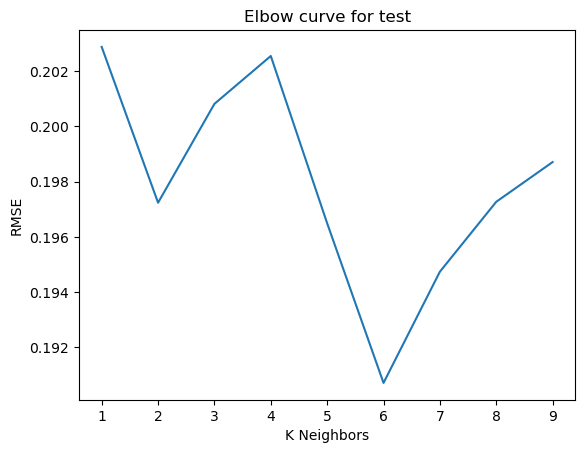

In [62]:
# KNN for fs DATASET
knnr = KNeighborsRegressor(n_neighbors=5)
knnr.fit(X_train_fs, y_train_fs)
y_pred = knnr.predict(X_test_fs)
error = sqrt(mean_squared_error(y_test_fs, y_pred))

print("RMSE of knn model: ", error)

# Elbow curve to determine the K value
def elbow(k):
    test = []
    for i in k:
        reg = KNeighborsRegressor(n_neighbors=i)
        reg.fit(X_train_fs, y_train_fs)

        tmp_pred = reg.predict(X_test_fs)
        temp_error = sqrt(mean_squared_error(tmp_pred, y_test_fs))
        test.append(temp_error)
    return test
k = range(1,10)
test= elbow(k)


# plotting the curve

plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('RMSE')
plt.title('Elbow curve for test')

As for the OLS dataset, The best k value is 6. Lets build a model with k = 6

In [63]:
knnr = KNeighborsRegressor(n_neighbors=6)
knnr.fit(X_train_fs, y_train_fs)
test_pred = knnr.predict(X_test_fs)
train_pred = knnr.predict(X_train_fs)
KNN_error_train_fs = sqrt(mean_squared_error(y_train_fs,train_pred))
KNN_error_test_fs = sqrt(mean_squared_error(y_test_fs, test_pred))

print("KNN Model for fs Dataset")
print("RMSE of Trained fs DATASET:", KNN_error_train_fs)
print("RMSE of Test fs Dataset:", KNN_error_test_fs)
FS_dict={}
FS_dict['model']="KNN"
FS_dict['Train_score'] = KNN_error_train_fs
FS_dict['Test_score'] = KNN_error_test_fs
Test_scores_fs.append(FS_dict)
print(Test_scores_fs)

KNN Model for fs Dataset
RMSE of Trained fs DATASET: 0.5752740223383638
RMSE of Test fs Dataset: 0.19071181203491244
[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.0125229479345839, 'Test_score': 0.8332366104991389}, {'model': 'KNN', 'Train_score': 0.5752740223383638, 'Test_score': 0.19071181203491244}]


**Decision Tree Regressor**

We will now build Decision tree regressor model for both PCA Dataset and OLS Dataset

In [82]:
#Decision tree regressor for pca dataset

dtr = DecisionTreeRegressor(random_state=30,max_depth=5)
dtr.fit(X_train_pca, y_train_pca)

train_pred = dtr.predict(X_train_pca)
test_pred = dtr.predict(X_test_pca)

DTR_error_train=sqrt(mean_squared_error(y_train_pca,train_pred))
DTR_error_test= sqrt(mean_squared_error(y_test_pca,test_pred))

print("DECSION TREE REGRESSOR FOR PCA DATASET")
print("RMSE of Trained PCA Data:", DTR_error_train)
print("RMSE of Test PCA Data:", DTR_error_test)
print(dtr.feature_importances_)
feature_importance = pd.DataFrame({'Importance': dtr.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)
PCA_dict={}
PCA_dict['model']="Decision Tree Regressor"
PCA_dict['Train_score'] = DTR_error_train
PCA_dict['Test_score'] = DTR_error_test
Test_scores_pca.append(PCA_dict)

DECSION TREE REGRESSOR FOR PCA DATASET
RMSE of Trained PCA Data: 0.4999347595919549
RMSE of Test PCA Data: 0.5791883187710001
[1.18445108e-01 1.65746501e-01 4.76567643e-03 5.77482164e-08
 5.12042574e-01 4.89713614e-04 4.83064240e-04 1.98027304e-01]
   Importance
4        0.51
7        0.20
1        0.17
0        0.12
2        0.00
5        0.00
6        0.00
3        0.00


From The above we can intrepret, That the fetaure number 4 has highest importance with value 0.51.

In [83]:
#Decision tree regressor for fs dataset

dtr = DecisionTreeRegressor(random_state=30,max_depth=5)
dtr.fit(X_train_fs, y_train_fs)

train_pred = dtr.predict(X_train_fs)
test_pred = dtr.predict(X_test_fs)

DTR_error_train=sqrt(mean_squared_error(y_train_fs,train_pred))
DTR_error_test= sqrt(mean_squared_error(y_test_fs,test_pred))

print("DECSION TREE REGRESSOR FOR fs DATASET")
print("RMSE of Trained fs Data:", DTR_error_train)
print("RMSE of Test fs Data:", DTR_error_test)
feature_importance = pd.DataFrame({'Importance': dtr.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)
FS_dict={}
FS_dict['model']="Decision Tree Regressor"
FS_dict['Train_score'] = DTR_error_train
FS_dict['Test_score'] = DTR_error_test
Test_scores_fs.append(FS_dict)

DECSION TREE REGRESSOR FOR fs DATASET
RMSE of Trained fs Data: 0.1461296207965868
RMSE of Test fs Data: 0.14923661153625656
   Importance
4        0.58
0        0.36
3        0.06
2        0.00
1        0.00
5        0.00


For the OLS Data, Feature 4 has highest importance with value 0.58

In [66]:
print(Test_scores_pca)
print(Test_scores_fs)

[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.012653407633636, 'Test_score': 0.8334387482675543}, {'model': 'KNN', 'Train_score': 0.3999022527613862, 'Test_score': 0.45501658587355925}, {'model': 'Decision Tree Regressor', 'Train_score': 0.4999347595919549, 'Test_score': 0.5791883187710001}]
[{'model': 'Linear Regression(Ridge)', 'Train_score': 1.0125229479345839, 'Test_score': 0.8332366104991389}, {'model': 'KNN', 'Train_score': 0.5752740223383638, 'Test_score': 0.19071181203491244}, {'model': 'Decision Tree Regressor', 'Train_score': 0.1461296207965868, 'Test_score': 0.14923661153625656}]


                      model  Train_score  Test_score
0  Linear Regression(Ridge)         1.01        0.83
1                       KNN         0.40        0.46
2   Decision Tree Regressor         0.50        0.58


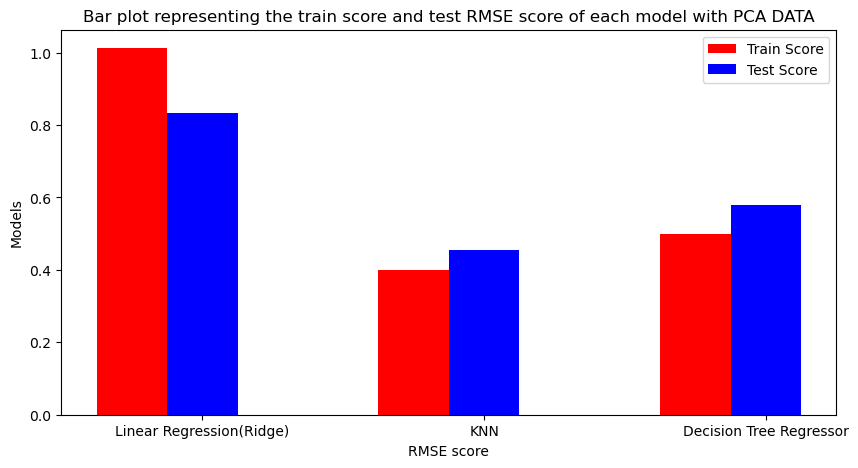

In [68]:
plt.figure(figsize=[10, 5])
data = pd.DataFrame(Test_scores_pca)
print(data)
X = np.arange(len(data.Train_score))
plt.bar(X, data.Train_score, color = 'r', width = 0.25)
plt.bar(X + 0.25, data.Test_score, color = 'b', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Train Score', 'Test Score'])

labels = data['model'].to_list()

# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(3)], labels)

# Giving the tilte for the plot
plt.title("Bar plot representing the train score and test RMSE score of each model with PCA DATA")
# Namimg the x and y axis
plt.xlabel('RMSE score')
plt.ylabel('Models')


# Displaying the bar plot
plt.show()

                      model  Train_score  Test_score
0  Linear Regression(Ridge)         1.01        0.83
1                       KNN         0.58        0.19
2   Decision Tree Regressor         0.15        0.15


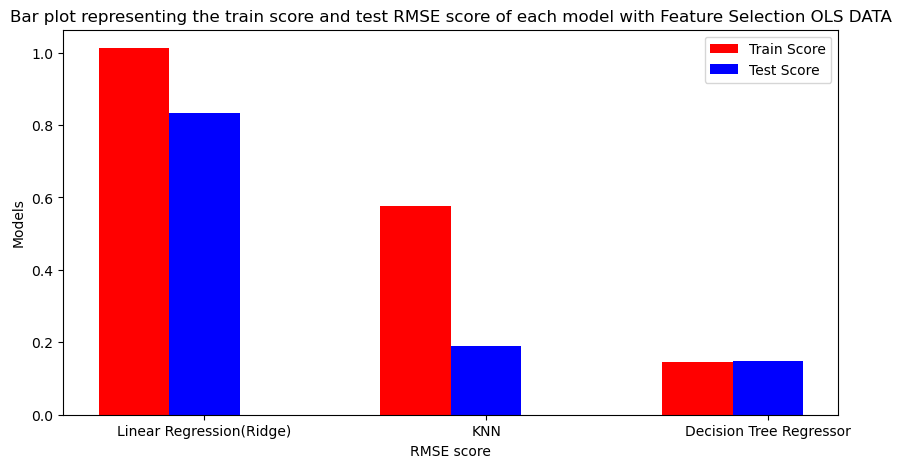

In [70]:
plt.figure(figsize=[10, 5])
data = pd.DataFrame(Test_scores_fs)
print(data)
X = np.arange(len(data.Train_score))
plt.bar(X, data.Train_score, color = 'r', width = 0.25)
plt.bar(X + 0.25, data.Test_score, color = 'b', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Train Score', 'Test Score'])

labels = data['model'].to_list()

# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(3)], labels)

# Giving the tilte for the plot
plt.title("Bar plot representing the train score and test RMSE score of each model with Feature Selection OLS DATA")
# Namimg the x and y axis
plt.xlabel('RMSE score')
plt.ylabel('Models')


# Displaying the bar plot
plt.show()